<div class="alert-danger">
Red colored boxes mean that the documentation is outdated and needs to be changed/replaced.
</div>

<div class="alert-warning">
Yellow colored boxes mean that the documentation is incomplete and needs to be finished.
</div>

<div class="alert-info">
Blue colored boxes are placeholders for optional additions that would improve and polish the notebook.
</div>

## Import Necessary Libraries and Packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import statistics
import seaborn as sns

from google.colab import files

%matplotlib inline

## Load the Preprocessed Data

In [ ]:
uploaded = files.upload()

Saving lin_filtered.csv to lin_filtered.csv


In [ ]:
# load preprocessed data file as a pandas dataframe
df = pd.read_csv('lin_filtered.csv', low_memory=False)

In [ ]:
df.head()

,Unnamed: 0,25,86,131,294,297,307,321,340,345,346,370,500,506,536,553,608,610,712,718,722,723,726,730,748,758,762,763,812,888,921,923,960,969,970,977,999,1027,1028,1032,...,4804,4809,4813,4814,4816,4817,4821,4822,4824,4844,4845,4881,4886,4901,4933,4944,5052,5065,5066,5075,5113,5122,5163,5164,5189,5201,5214,5251,5262,5275,5282,5283,5330,5331,5369,5377,5387,5407,activity,nametags
0,0,-0.031,-0.024,-0.021,-4.109,0.003,-0.103000,2.551,3.024,-0.442,-0.001,1.038,0.048,-0.019,0.033,0.040000,-0.180,-0.918,-0.459,0.039,-1.460,1.732,0.160,-0.093,0.225,-0.394,-0.560,-0.104,0.545727,0.011,-0.031,-0.010,2.869,-0.040,0.075,0.015,0.207,-0.00504,-16.502,0.026,...,-14.342,-1.213727,0.033067,-2.246,24.298,48.519,0.120300,0.582294,0.227375,0.005,0.020,-0.005,-0.060,-0.049,-0.034,-0.004000,0.025,-0.034,-0.014,-0.021,0.004,-0.008,0.041,0.044,0.043,-0.037,-0.039,0.016,-0.029,0.050,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,-0.007,False,a119e_l125p
1,1,-0.019,0.006,-0.038,-4.111,0.006,-0.054667,-0.002,2.952,-0.366,0.009,0.992,0.001,-0.002,0.031,0.016286,0.078,-0.023,-0.416,0.066,-1.446,1.768,0.026,0.005,-0.004,-1.017,-0.096,-0.089,0.775091,-0.003,-0.023,-0.030,2.896,0.013,0.093,0.124,2.650,0.25640,-16.527,0.008,...,4.115,-0.619045,-1.028600,-1.808,21.268,62.454,-0.112233,0.537647,0.278125,-0.012,0.007,-0.003,-0.082,-0.029,-0.017,0.010000,0.005,-0.021,-0.021,-0.009,-0.009,-0.001,0.022,0.022,0.026,-0.012,-0.020,0.013,-0.012,0.034,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,0.005,False,a119e_r283k_a353v
2,2,-0.036,-0.056,-0.033,-4.107,-0.012,-0.099333,-0.002,3.031,-0.089,-0.019,1.051,0.041,-0.024,0.042,-1.114571,-0.216,-0.933,-0.457,0.048,-1.455,1.739,-2.953,-0.062,0.222,-1.010,-0.205,-0.103,0.535364,-0.005,-0.025,-0.020,2.862,-0.048,0.058,0.002,0.200,-0.00790,-16.508,0.018,...,-11.706,0.489000,-0.503633,-2.324,24.274,49.118,0.648200,0.396000,0.027750,0.012,0.010,-0.009,-0.070,-0.055,-0.027,-0.002000,0.042,-0.029,-0.015,-0.020,0.003,-0.011,0.030,0.051,0.043,-0.034,-0.045,0.018,-0.032,0.053,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,-0.018,False,c135y
3,3,-0.058,-0.116,-0.039,-4.106,-0.038,-0.134333,-0.017,-0.033,-0.056,-0.046,1.180,4.554,4.426,0.063,-1.086357,-0.536,-1.128,-0.476,0.024,-1.473,1.782,-2.943,-0.033,0.217,-1.035,-0.533,-0.105,0.755273,-0.045,-0.063,-0.083,2.880,-0.088,-0.060,-0.046,0.201,0.22802,-16.508,0.018,...,-23.103,-1.607500,0.218600,-2.305,16.750,56.411,0.537033,0.455118,0.050625,0.028,-0.003,-0.021,-0.103,-0.082,-0.065,-0.492000,0.038,-0.042,0.003,-0.026,0.021,-0.001,0.031,0.062,0.057,-0.048,-0.067,0.189,-0.069,0.076,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,-0.049,False,c135y_e285m
4,4,-0.011,0.012,-0.037,-4.110,0.011,-0.057333,0.000,2.974,-0.362,0.017,0.949,0.010,0.005,0.025,0.008214,-0.055,-0.927,-0.409,0.080,-1.434,1.805,0.036,-0.004,-0.004,-1.108,-0.128,-0.098,0.782091,0.005,-0.054,-0.030,2.896,-0.004,-2.720,-2.106,0.149,0.25992,0.000,0.008,...,2.702,-1.240091,-1.339100,-2.378,20.821,61.475,-2.289233,0.309824,-0.122750,-0.014,0.012,0.007,-0.030,-0.027,-0.011,-0.371001,0.004,-0.017,-0.019,-0.007,-0.011,0.018,0.018,0.023,0.022,-0.007,-0.014,0.148,-0.012,0.024,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,0.013,False,c135y_e285v


In [ ]:
df.columns

Index(['Unnamed: 0', '25', '86', '131', '294', '297', '307', '321', '340',
       '345',
       ...
       '5282', '5283', '5330', '5331', '5369', '5377', '5387', '5407',
       'activity', 'nametags'],
      dtype='object', length=345)

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df.head()

,25,86,131,294,297,307,321,340,345,346,370,500,506,536,553,608,610,712,718,722,723,726,730,748,758,762,763,812,888,921,923,960,969,970,977,999,1027,1028,1032,1035,...,4804,4809,4813,4814,4816,4817,4821,4822,4824,4844,4845,4881,4886,4901,4933,4944,5052,5065,5066,5075,5113,5122,5163,5164,5189,5201,5214,5251,5262,5275,5282,5283,5330,5331,5369,5377,5387,5407,activity,nametags
0,-0.031,-0.024,-0.021,-4.109,0.003,-0.103000,2.551,3.024,-0.442,-0.001,1.038,0.048,-0.019,0.033,0.040000,-0.180,-0.918,-0.459,0.039,-1.460,1.732,0.160,-0.093,0.225,-0.394,-0.560,-0.104,0.545727,0.011,-0.031,-0.010,2.869,-0.040,0.075,0.015,0.207,-0.00504,-16.502,0.026,0.012,...,-14.342,-1.213727,0.033067,-2.246,24.298,48.519,0.120300,0.582294,0.227375,0.005,0.020,-0.005,-0.060,-0.049,-0.034,-0.004000,0.025,-0.034,-0.014,-0.021,0.004,-0.008,0.041,0.044,0.043,-0.037,-0.039,0.016,-0.029,0.050,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,-0.007,False,a119e_l125p
1,-0.019,0.006,-0.038,-4.111,0.006,-0.054667,-0.002,2.952,-0.366,0.009,0.992,0.001,-0.002,0.031,0.016286,0.078,-0.023,-0.416,0.066,-1.446,1.768,0.026,0.005,-0.004,-1.017,-0.096,-0.089,0.775091,-0.003,-0.023,-0.030,2.896,0.013,0.093,0.124,2.650,0.25640,-16.527,0.008,0.000,...,4.115,-0.619045,-1.028600,-1.808,21.268,62.454,-0.112233,0.537647,0.278125,-0.012,0.007,-0.003,-0.082,-0.029,-0.017,0.010000,0.005,-0.021,-0.021,-0.009,-0.009,-0.001,0.022,0.022,0.026,-0.012,-0.020,0.013,-0.012,0.034,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,0.005,False,a119e_r283k_a353v
2,-0.036,-0.056,-0.033,-4.107,-0.012,-0.099333,-0.002,3.031,-0.089,-0.019,1.051,0.041,-0.024,0.042,-1.114571,-0.216,-0.933,-0.457,0.048,-1.455,1.739,-2.953,-0.062,0.222,-1.010,-0.205,-0.103,0.535364,-0.005,-0.025,-0.020,2.862,-0.048,0.058,0.002,0.200,-0.00790,-16.508,0.018,0.007,...,-11.706,0.489000,-0.503633,-2.324,24.274,49.118,0.648200,0.396000,0.027750,0.012,0.010,-0.009,-0.070,-0.055,-0.027,-0.002000,0.042,-0.029,-0.015,-0.020,0.003,-0.011,0.030,0.051,0.043,-0.034,-0.045,0.018,-0.032,0.053,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,-0.018,False,c135y
3,-0.058,-0.116,-0.039,-4.106,-0.038,-0.134333,-0.017,-0.033,-0.056,-0.046,1.180,4.554,4.426,0.063,-1.086357,-0.536,-1.128,-0.476,0.024,-1.473,1.782,-2.943,-0.033,0.217,-1.035,-0.533,-0.105,0.755273,-0.045,-0.063,-0.083,2.880,-0.088,-0.060,-0.046,0.201,0.22802,-16.508,0.018,0.003,...,-23.103,-1.607500,0.218600,-2.305,16.750,56.411,0.537033,0.455118,0.050625,0.028,-0.003,-0.021,-0.103,-0.082,-0.065,-0.492000,0.038,-0.042,0.003,-0.026,0.021,-0.001,0.031,0.062,0.057,-0.048,-0.067,0.189,-0.069,0.076,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,-0.049,False,c135y_e285m
4,-0.011,0.012,-0.037,-4.110,0.011,-0.057333,0.000,2.974,-0.362,0.017,0.949,0.010,0.005,0.025,0.008214,-0.055,-0.927,-0.409,0.080,-1.434,1.805,0.036,-0.004,-0.004,-1.108,-0.128,-0.098,0.782091,0.005,-0.054,-0.030,2.896,-0.004,-2.720,-2.106,0.149,0.25992,0.000,0.008,0.003,...,2.702,-1.240091,-1.339100,-2.378,20.821,61.475,-2.289233,0.309824,-0.122750,-0.014,0.012,0.007,-0.030,-0.027,-0.011,-0.371001,0.004,-0.017,-0.019,-0.007,-0.011,0.018,0.018,0.023,0.022,-0.007,-0.014,0.148,-0.012,0.024,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,0.013,False,c135y_e285v


#### Pop Out Nametags Column

In [ ]:
nametags = df.pop('nametags').astype(str)
print(nametags)

0              a119e_l125p
1        a119e_r283k_a353v
2                    c135y
3              c135y_e285m
4              c135y_e285v
               ...        
16586    y220c_t230c_n239y
16587    y220c_y234f_n239l
16588                y234c
16589          y234c_a119e
16590          y234f_n239l
Name: nametags, Length: 16591, dtype: object


In [ ]:
df.head()

,25,86,131,294,297,307,321,340,345,346,370,500,506,536,553,608,610,712,718,722,723,726,730,748,758,762,763,812,888,921,923,960,969,970,977,999,1027,1028,1032,1035,...,4802,4804,4809,4813,4814,4816,4817,4821,4822,4824,4844,4845,4881,4886,4901,4933,4944,5052,5065,5066,5075,5113,5122,5163,5164,5189,5201,5214,5251,5262,5275,5282,5283,5330,5331,5369,5377,5387,5407,activity
0,-0.031,-0.024,-0.021,-4.109,0.003,-0.103000,2.551,3.024,-0.442,-0.001,1.038,0.048,-0.019,0.033,0.040000,-0.180,-0.918,-0.459,0.039,-1.460,1.732,0.160,-0.093,0.225,-0.394,-0.560,-0.104,0.545727,0.011,-0.031,-0.010,2.869,-0.040,0.075,0.015,0.207,-0.00504,-16.502,0.026,0.012,...,-18.015,-14.342,-1.213727,0.033067,-2.246,24.298,48.519,0.120300,0.582294,0.227375,0.005,0.020,-0.005,-0.060,-0.049,-0.034,-0.004000,0.025,-0.034,-0.014,-0.021,0.004,-0.008,0.041,0.044,0.043,-0.037,-0.039,0.016,-0.029,0.050,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,-0.007,False
1,-0.019,0.006,-0.038,-4.111,0.006,-0.054667,-0.002,2.952,-0.366,0.009,0.992,0.001,-0.002,0.031,0.016286,0.078,-0.023,-0.416,0.066,-1.446,1.768,0.026,0.005,-0.004,-1.017,-0.096,-0.089,0.775091,-0.003,-0.023,-0.030,2.896,0.013,0.093,0.124,2.650,0.25640,-16.527,0.008,0.000,...,-9.978,4.115,-0.619045,-1.028600,-1.808,21.268,62.454,-0.112233,0.537647,0.278125,-0.012,0.007,-0.003,-0.082,-0.029,-0.017,0.010000,0.005,-0.021,-0.021,-0.009,-0.009,-0.001,0.022,0.022,0.026,-0.012,-0.020,0.013,-0.012,0.034,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,0.005,False
2,-0.036,-0.056,-0.033,-4.107,-0.012,-0.099333,-0.002,3.031,-0.089,-0.019,1.051,0.041,-0.024,0.042,-1.114571,-0.216,-0.933,-0.457,0.048,-1.455,1.739,-2.953,-0.062,0.222,-1.010,-0.205,-0.103,0.535364,-0.005,-0.025,-0.020,2.862,-0.048,0.058,0.002,0.200,-0.00790,-16.508,0.018,0.007,...,-17.386,-11.706,0.489000,-0.503633,-2.324,24.274,49.118,0.648200,0.396000,0.027750,0.012,0.010,-0.009,-0.070,-0.055,-0.027,-0.002000,0.042,-0.029,-0.015,-0.020,0.003,-0.011,0.030,0.051,0.043,-0.034,-0.045,0.018,-0.032,0.053,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,-0.018,False
3,-0.058,-0.116,-0.039,-4.106,-0.038,-0.134333,-0.017,-0.033,-0.056,-0.046,1.180,4.554,4.426,0.063,-1.086357,-0.536,-1.128,-0.476,0.024,-1.473,1.782,-2.943,-0.033,0.217,-1.035,-0.533,-0.105,0.755273,-0.045,-0.063,-0.083,2.880,-0.088,-0.060,-0.046,0.201,0.22802,-16.508,0.018,0.003,...,-23.006,-23.103,-1.607500,0.218600,-2.305,16.750,56.411,0.537033,0.455118,0.050625,0.028,-0.003,-0.021,-0.103,-0.082,-0.065,-0.492000,0.038,-0.042,0.003,-0.026,0.021,-0.001,0.031,0.062,0.057,-0.048,-0.067,0.189,-0.069,0.076,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,-0.049,False
4,-0.011,0.012,-0.037,-4.110,0.011,-0.057333,0.000,2.974,-0.362,0.017,0.949,0.010,0.005,0.025,0.008214,-0.055,-0.927,-0.409,0.080,-1.434,1.805,0.036,-0.004,-0.004,-1.108,-0.128,-0.098,0.782091,0.005,-0.054,-0.030,2.896,-0.004,-2.720,-2.106,0.149,0.25992,0.000,0.008,0.003,...,-9.191,2.702,-1.240091,-1.339100,-2.378,20.821,61.475,-2.289233,0.309824,-0.122750,-0.014,0.012,0.007,-0.030,-0.027,-0.011,-0.371001,0.004,-0.017,-0.019,-0.007,-0.011,0.018,0.018,0.023,0.022,-0.007,-0.014,0.148,-0.012,0.024,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,0.013,False


# Random Forest Classifier: Baseline Model


The first classification model that I'll be using is a Random Forest Classifier with two different methods of hyperparameter optimization: RandomSearch and Bayesian Optimization.

In [ ]:
# import from sklearn
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

### Create Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = df.iloc[:, 0:342] # features
y = df.activity # target variable

feature_list = list(X.columns) # save feature names for later

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=420)

### Scale Data to Prepare for Model Creation

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

# build scaler based on training data and apply it to test data to then also scale the test data
scaler = MaxAbsScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Train and Fit the RandomForestClassifier Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 500, random_state=420, n_jobs=-1)

model1 = clf.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)
y_pred_prob = model1.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.994
Random Forest: f1-score=0.991


The Random Forest classifier model shows an overall accuracy of 99.4% and an F1-score of 0.991 - both of which look very good at first glance, but are misleading! 

My guess is that this model has a high accuracy score due to overfitting. Random Forest Classifiers have a tendency to overfit, especially when there is a large number of trees (n_estimators). For this reason, I will use two different methods for hyperparameter optimization - RandomizedSearchCV and Bayesian Optimization - to train Random Forest Classifiers and then compare the results with this baseline model. In the next section, I will take a closer look at the model's performance.

### Evaluate Model Performance

To evaluate my Random Forest Classifier, I will be visualizing the model's performance using a confusion matrix, and then use the classification report to view the precision, recall, and f1-scores for each category. The confusion matrix will give me an overall idea of the model's performance, while the classification report will help me understand my model's performance in a more nuanced way.

In [ ]:
conf = confusion_matrix(y_test, y_pred).astype('float')

In [ ]:
conf = conf / conf.sum(axis=1)[:, np.newaxis]

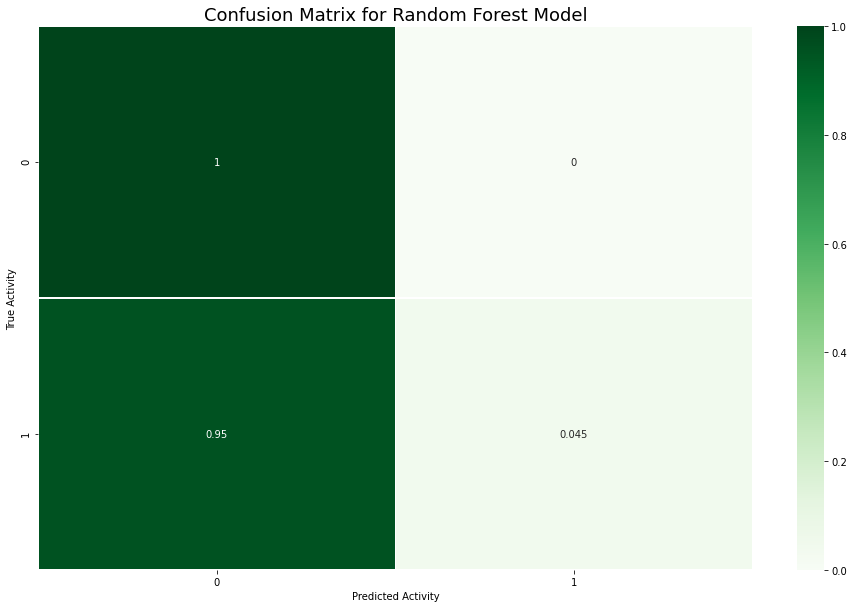

In [ ]:
#plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(conf, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
sns.set(font_scale=1.5)

_ = plt.xlabel('Predicted Activity')
_ = plt.ylabel('True Activity')
_ = plt.title('Confusion Matrix for Random Forest Model')
plt.show()

The 0's correspond to **inactive p53 proteins**, and the 1's correspond to **active p53 proteins**.

This confusion matrix shows that my classifier had trouble correctly classifying the active p53 proteins as active, as seen by the large proportion of false negatives. On the other hand, my classifier did very well at correctly labeling *inactive* p53 proteins. 

From looking at the confusion matrix, I can tell that this model is a *naive classifier* - it nearly always predicts "0", or inactive, for the protein. Statistically, this is the best way for the model to maximize the chances of making a correct prediction, since there is a huge class imbalance in the training data.

This makes sense, as the data is very imbalanced with regards to inactive vs active protein data. There is much more data for inactive proteins in the dataset than for active proteins. I saw this imbalance in the data during the exploratory data analysis that was performed earlier. 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      3297
        True       1.00      0.05      0.09        22

    accuracy                           0.99      3319
   macro avg       1.00      0.52      0.54      3319
weighted avg       0.99      0.99      0.99      3319



The imbalance in the data is further confirmed by the low recall and low f1-scores for the "True" (aka "Active" p53) category. This is due to the low amount of "True" observations within the dataset, which does not allow the classifier enough data to learn how to predict the "True" class. This is a common problem with classifiers made with imbalanced data. 

To address this problem, I will oversample my minority class by generating synthetic data (SMOTE), which will create a more balanced dataset for my classifier model to learn from. I will also be combining this method with the Tomek Links undersampling method, which will create a clearer decision boundary for my binary classifier.

Before I move on, however, I am going to visualize the top 10 feature importances from this Random Forest classifier, so that I can compare these results with those of following models:

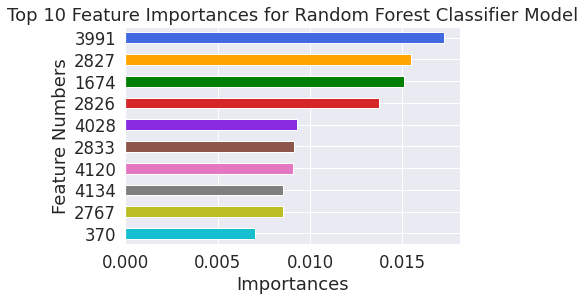

In [ ]:
feature_importances = pd.Series(model1.feature_importances_, index=feature_list)
_ = feature_importances.nlargest(10).plot(kind='barh', color=['royalblue', 'orange', 'green', 'tab:red', 'blueviolet', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']).invert_yaxis()

_ = plt.ylabel('Feature Numbers')
_ = plt.xlabel('Importances')
_ = plt.title('Top 10 Feature Importances for Random Forest Classifier Model')
plt.show()

Looks like the **most importance features** for this Random Forest Classifier model are: **3991, 2827, 1674, 2826, 4028, 2833, 4120, 4134, 2767, and 370**.

All of the Top 10 Most Important Features are **Electrostatic and Surface-Based Features**! This is very interesting, because I would have thought that the Distance-Based Features would be more important for indicating wild-type p53 function. However, this feature list is not reliable due to the extremely low recall for the positive class. Thus, I will be comparing these Top Features with those of following models after resampling the data and hyperparameter tuning my model algorithms.

# Random Forest with Oversampling/Undersampling and Randomized Search

## Balance the Imbalanced Classes with SMOTETomek

SMOTE is an oversampling method that interpolates synthetic observations between the existing ones in the dataset. Tomek Links are pairs of nearest neighbors that have different classes, which in this case, are instances of the majority and minority class that are next to each other. Tomek Links are used for undersampling the majority class by getting rid of those observations which are next to the minority class examples, thus creating a more distinct decision boundary for the classifier.

SMOTETomek is a combined method that oversamples the minority class and undersamples the majority class. This method is preferable to using SMOTE by itself since it cleans up the noise that SMOTE tends to create in the sample space.

In [ ]:
# import imblearn libraries for SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

In [ ]:
# define the resampler, smt
# oversample minority class, undersample majority class
smt = SMOTETomek(random_state=420, smote=SMOTE(sampling_strategy='minority'), tomek=TomekLinks(sampling_strategy='majority'))

# resample the training dataset
X_res, y_res = smt.fit_resample(X_train_scaled, y_train) # only for training data!!

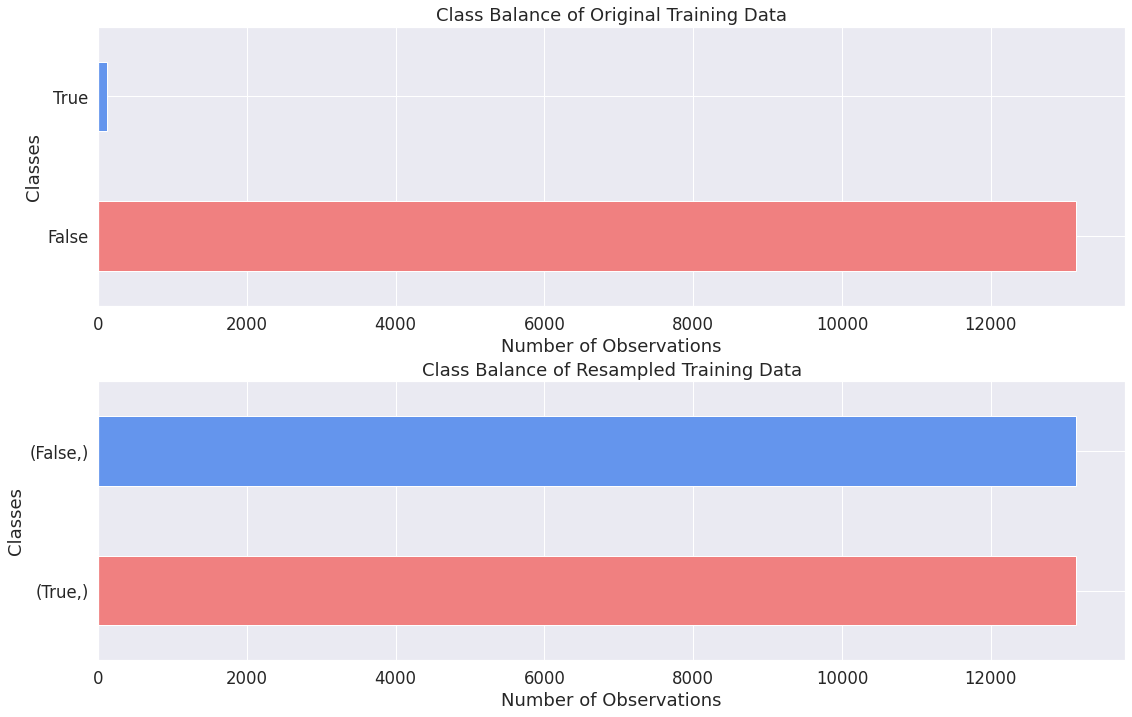

In [ ]:
# visualize the two classes with a barchart to confirm balance
y_res_df = pd.DataFrame(y_res) #resampled training labels
y_tr_df = pd.DataFrame(y_train) #original training labels

plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plt.tight_layout()
_ = y_train.value_counts().plot(kind='barh', color=['lightcoral', 'cornflowerblue'])
_ = plt.xlabel('Number of Observations')
_ = plt.ylabel('Classes')
_ = plt.title('Class Balance of Original Training Data')

plt.subplot(2, 1, 2)
plt.tight_layout()
_ = y_res_df.value_counts().plot(kind='barh', color=['lightcoral', 'cornflowerblue'])
_ = plt.xlabel('Number of Observations')
_ = plt.ylabel('Classes')
_ = plt.title('Class Balance of Resampled Training Data')

plt.show()

In [ ]:
# run a baseline Random Forest model with the resampled data and call it model2

model2 = clf.fit(X_res, y_res) # use X_res and y_res instead of X_train_scaled and y_train
y_pred = model2.predict(X_test_scaled)
y_pred_prob = model2.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9921839505381675


In [ ]:
# classification report for model 2
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3297
        True       0.46      0.27      0.34        22

    accuracy                           0.99      3319
   macro avg       0.73      0.64      0.67      3319
weighted avg       0.99      0.99      0.99      3319



<div class="alert-warning">
Resampling the training data with SMOTETomek helped increase the recall for the positive class from 0.05 to 0.27 and the f1-score from 0.09 to 0.35! That's a significant improvement, and a great starting point. I want to continue to maximize the f1-score, which effectively balances the precision and recall, in further models.
</div>

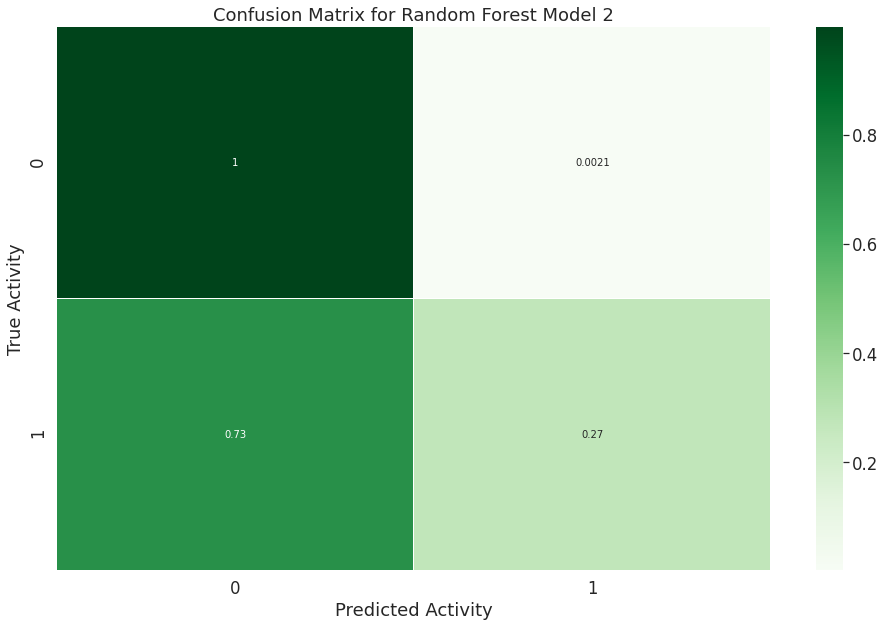

In [ ]:
# plot confusion matrix for model 2
conf2 = confusion_matrix(y_test, y_pred).astype('float')
conf2 = conf2 / conf2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 10))
sns.heatmap(conf2, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
sns.set(font_scale=1.5)

_ = plt.xlabel('Predicted Activity')
_ = plt.ylabel('True Activity')
_ = plt.title('Confusion Matrix for Random Forest Model 2')
plt.show()

### Increase Weights on the Minority Class

In [ ]:
# add class weights in favor of the minority (False/Inactive) class and run Random Forest model
# model3, clf2

clf2 = RandomForestClassifier(n_estimators = 500, class_weight={0:1, 1:10}, random_state=420, n_jobs=-1)

model3 = clf2.fit(X_res, y_res) # use X_res and y_res instead of X_train_scaled and y_train

y_pred = model3.predict(X_test_scaled)
y_pred_prob = model3.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
# classification report for model 3
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99      3297
        True       0.25      0.27      0.26        22

    accuracy                           0.99      3319
   macro avg       0.62      0.63      0.63      3319
weighted avg       0.99      0.99      0.99      3319



<div class="alert-warning">
By increasing the class weight on the positive class, the random forest algorithm now penalizes incorrect classifications of the positive class ten times more than incorrect classifications of the negative class. 
This change did not increase the f1-score, but it did even out the precision and recall for the positive class. I want to explore this more as a hyperparameter to tune.
</div>

## Hyperparameter Tuning with Randomized Search

Let's start by taking a look at the parameters used by the previous Random Forest model:

In [ ]:
print('Current Random Forest Parameters:\n ', clf.get_params())

Current Random Forest Parameters:
  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 420, 'verbose': 0, 'warm_start': False}


<div class="alert-danger">

Out of these parameters, I will be focusing on the tuning the following:

+ max_features: max number of features considered when splitting a node
+ min_samples_split: minimum number of samples required to split a node
+ min_samples_leaf: minimum number of samples required at each leaf
+ n_estimators: number of trees in the forest
    
</div>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# max_features
max_features=['auto', 'sqrt']

# min_samples_split
min_samples_split = [i for i in np.linspace(2, 40, 20)]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# n_estimators
n_estimators = [i for i in np.linspace(200, 2000, 20)]

In [ ]:
# create the random parameter grid
random_grid = {'n_estimators': n_estimators
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
# create a RandomForestClassifier to tune
clf = RandomForestClassifier(random_state=420)

# create random search model
model4 = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=420, n_jobs=-1)

# fit random search model on resampled data
model4.fit(X_res, y_res)

In [ ]:
# view best hyperparameters from fitting the random search
print(model4.best_params_)

<div class="alert-danger">
The best parameters from the Randomized Search are:

{'n_estimators': 673, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

To deal with the imbalance in the dataset, I will also be adding the class_weights parameter to the Random Forest Classifier and assigning more weights to the "active" class.

+ class_weight: class weights affect how the model is penalized for misclassifying examples of each class

</div>

In [ ]:
# compute class_weights based on original y_train
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_res), y=y_train)

In [ ]:
weights # weights for original training data

array([ 0.50456204, 55.3       ])

In [ ]:
# compute class_weights based on resampled y_train
weights_res = compute_class_weight(class_weight='balanced', classes=np.unique(y_res), y=y_res)

In [ ]:
weights_res # weights for resampled y_train labels

array([1., 1.])

# Binary Logistic Regression Classifier

Logistic Regression is a solid algorithm choice for modeling this data for a few reasons:

+ The dependent (target) variable is binary
+ The features have already been filtered using linear correlation, so there should be little collinearity between variables
+ My sample sizes are large

I will be training my model on the rescaled, resampled data that I used for my Random Forest Classifiers.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l1', class_weight='balanced', random_state=420, solver='saga', multi_class='ovr', n_jobs=-1, warm_start=True)

logreg.fit(X_res, y_res) # fit on training data
y_pred = logreg.predict(X_test_scaled)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


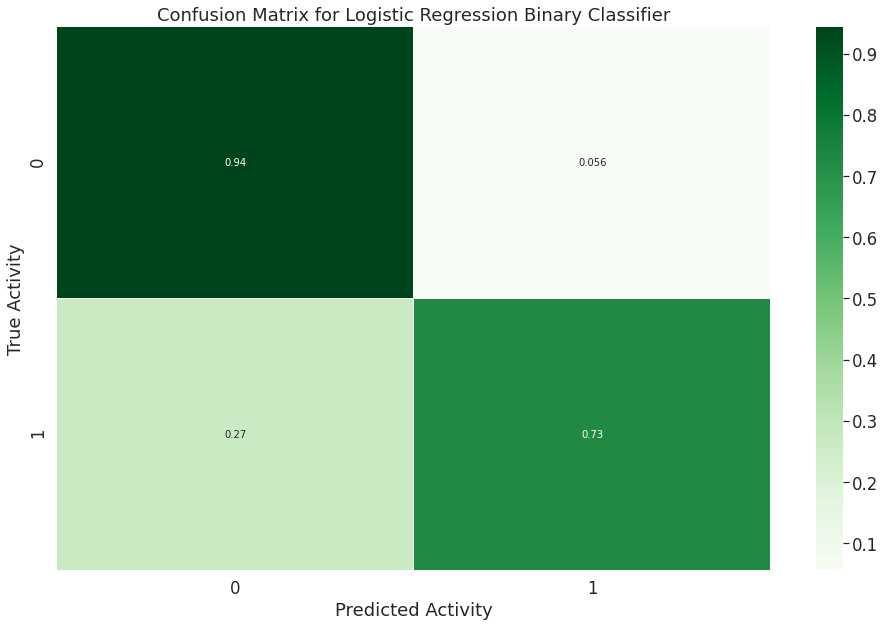

In [ ]:
# plot confusion matrix for logistic regression model
conf_logreg = confusion_matrix(y_test, y_pred).astype('float')
conf_logreg = conf_logreg / conf_logreg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 10))
sns.heatmap(conf_logreg, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
sns.set(font_scale=1.5)

_ = plt.xlabel('Predicted Activity')
_ = plt.ylabel('True Activity')
_ = plt.title('Confusion Matrix for Logistic Regression Binary Classifier')
plt.show()

In [ ]:
# show the classification report for logistic regression model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97      3297
        True       0.08      0.73      0.14        22

    accuracy                           0.94      3319
   macro avg       0.54      0.84      0.56      3319
weighted avg       0.99      0.94      0.96      3319



The Logistic Regression model shows a high recall for both classes, with the recall for the positive class being 0.73! A high recall indicates a low false negative rate, which is exactly what I want. Since the positive class, which are transcriptionally active p53 mutants, are so rare, I want to make sure that as many of them as possible are correctly classified as being "active". 
On the other hand, this model has very low precision for the positive class, and I can see from the confusion matrix that some of the "active" p53 mutants were incorrectly classified as being "inactive". This is okay, since minimizing the false negatives is more important for my classification problem.

The Logistic Regression classifier performed better than any of the Random Forest Classifiers. 

In [ ]:
# most important features for logistic regression model -> abs value of coefs

# Imbalanced Classification with XGBoost

explain what you're going to do and why

# Conclusions

explain which model you chose and evaluate + interpret the model performance + most important features for the model
